#### Aug. 10, 2018 320pm

In [2]:
import numpy   as np
import pandas  as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from nltk.corpus import stopwords

import re

---

### Large Pickled Dataset



In [3]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 868 ms, sys: 512 ms, total: 1.38 s
Wall time: 2.5 s


In [4]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 88 ms, sys: 36 ms, total: 124 ms
Wall time: 259 ms


In [5]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923002 entries, 0 to 923001
Data columns (total 17 columns):
business_id    923002 non-null object
name           923002 non-null object
review_id      923002 non-null object
stars          923002 non-null int64
date           923002 non-null datetime64[ns]
text           923002 non-null object
useful         923002 non-null int64
funny          923002 non-null int64
cool           923002 non-null int64
city           923002 non-null object
state          923002 non-null object
Thai           923002 non-null float64
Italian        923002 non-null float64
Indian         923002 non-null float64
Chinese        923002 non-null float64
Mexican        923002 non-null float64
Text_length    923002 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 119.7+ MB


In [6]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 16.8 s, sys: 152 ms, total: 16.9 s
Wall time: 19.6 s


In [7]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 700 ms, sys: 0 ns, total: 700 ms
Wall time: 702 ms


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [9]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [10]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])

In [11]:
vectorizer = CountVectorizer(stop_words=stopWords)

#### Vectorize Review Text

In [12]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 46.4 s, sys: 1.38 s, total: 47.7 s
Wall time: 52.2 s


In [13]:
X_train_term.shape

(646101, 140728)

In [14]:
ftrs = vectorizer.get_feature_names()

---

#### Mutlinomial NB - Train

In [16]:
from sklearn.naive_bayes import MultinomialNB

In [17]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


In [18]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 340 ms, sys: 80 ms, total: 420 ms
Wall time: 425 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [19]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 19.2 s, sys: 80 ms, total: 19.2 s
Wall time: 19.3 s


In [20]:
X_test_term.shape

(276901, 140728)

In [21]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 92 ms, sys: 16 ms, total: 108 ms
Wall time: 108 ms


In [22]:
len(pred)

276901

In [23]:
pred[:30]

array([1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [24]:
np.unique(pred)

array([0., 1.])

In [25]:
y_test[:10]

20692     1.0
21795     0.0
417626    1.0
797567    0.0
802882    1.0
846146    0.0
155108    0.0
810370    1.0
224828    0.0
181313    0.0
Name: vegFriendly, dtype: float64

In [26]:
pred[:10]

array([1., 0., 1., 0., 1., 0., 0., 1., 0., 0.])

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [28]:
lbls = ['vegFriendly', 'Non-vegFriendly']

cm = confusion_matrix(y_test, pred)
cm

array([[201223,  18971],
       [ 21884,  34823]])

In [29]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.90      0.91      0.91    220194
        1.0       0.65      0.61      0.63     56707

avg / total       0.85      0.85      0.85    276901



In [30]:
accuracy_score(y_test, pred)

0.8524562930433621

In [31]:
precision_score(y_test, pred)

0.6473398520281072

In [32]:
recall_score(y_test, pred)

0.6140864443543125

In [33]:
f1_score(y_test, pred)

0.6302748391417271

Confusion matrix, without normalization


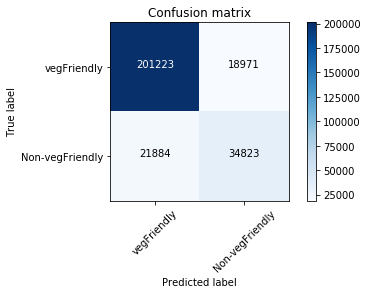

In [34]:
plot_confusion_matrix(cm,lbls)

In [35]:
y_score = M_NB_model.predict_proba(X_test_term)[:,1]

In [36]:
y_score[:10]

array([9.99996294e-01, 2.08732749e-01, 1.00000000e+00, 7.49493924e-04,
       9.32239776e-01, 9.96965523e-09, 1.08319646e-01, 8.49991145e-01,
       1.33773305e-02, 3.61964768e-02])

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)

AUC score: 0.8553965392695501


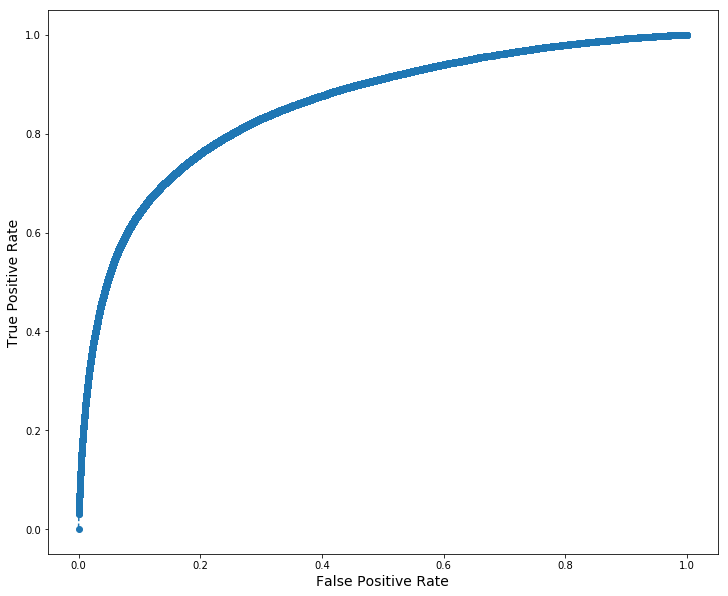

In [38]:
plt.figure(figsize=(12,10))
plt.plot(fpr, tpr, 'o--')
plt.ylabel("True Positive Rate",  fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14);
print("AUC score:", roc_auc_score(y_test, y_score))

In [1]:
# importances = M_NB_model.feature_importances_

# importances

log odds of priors

In [40]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [41]:
show_most_informative_features(vectorizer, M_NB_model, 20)

	-15.7094	aaaaa          		-4.0069	food           
	-15.7094	aaaaaa         		-4.6525	great          
	-15.7094	aaaaaaaaaa     		-4.9527	service        
	-15.7094	aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg		-5.1149	one            
	-15.7094	aaaaaaaaaaaaaauthentic		-5.1263	time           
	-15.7094	aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww		-5.1575	back           
	-15.7094	aaaaaaaaaaaaahhhhhhh		-5.1915	go             
	-15.7094	aaaaaaaaaaaand 		-5.2368	get            
	-15.7094	aaaaaaaaaand   		-5.2393	chicken        
	-15.7094	aaaaaaaaargh   		-5.2975	would          
	-15.7094	aaaaaaaahhhhhhhhh		-5.3318	restaurant     
	-15.7094	aaaaaaaamazing 		-5.3336	also           
	-15.7094	aaaaaaaawesooooooooooooome		-5.3510	delicious      
	-15.7094	aaaaaaahhhhhh  		-5.4248	love           
	-15.7094	aaaaaaamaaaaazing		-5.4295	menu           
	-15.7094	aaaaaaand      		-5.4369	vegan          
	-15.7094	aaaaaaggghhh   		-5.4560	try            
	-15.7094	aaaaaah        		-5.5390	orde

In [51]:
M_NB_model.feature_log_prob_.shape

(2, 140728)

ratio of posteriors for both classes

foo = M_NB_model.feature_log_prob_

bar = M_NB_model.class_log_prior_

spam = (foo[1,:] - foo[0,:] + bar[1] - bar[0])

inds = np.argsort(spam)[-1:-200:-1]

spam[inds]

np.array(ftrs)[inds]

In [44]:
M_NB_model.coef_

array([[-13.51216918, -13.76348361, -13.91763429, ..., -15.70939376,
        -15.70939376, -15.70939376]])

In [1]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')